In [ ]:
# !pip install tslearn

In [ ]:
import pandas as pd
from matplotlib import pyplot
import seaborn as sn
import matplotlib.pyplot as plt
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.metrics import dtw
import numpy as np
import scipy.stats as stats

Time Lagged Cross Correlation (TLCC) is a statistical technique used in time series analysis to measure the similarity between two time series at different time lags. TLCC is particularly useful in situations where we want to investigate the relationship between two variables that are both time series, but where there may be a time delay or lag between them.

The TLCC function calculates the correlation coefficient between two time series at a given time lag. It is similar to the standard cross-correlation function, but with an additional time lag parameter.

In practice, TLCC is often used to identify causal (not necessarily tru casuality) relationships between two variables in a time series context. For example, it can be used to investigate the relationship between stock prices and exchange rates or between weather patterns and crop yields.

NOTE: There can be almost no correlation between the two series when we pair the data at the same time point (what pearson's coefficient does). But sometimes, two time series move synchronously at different time point and show correlation.

In [ ]:
#https://www.datainsightonline.com/post/cross-correlation-with-two-time-series-in-python
# Explains why TLCC is so important and we can't do with simple Pearson's Coefficient for two time series.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/Transfer learning project/UCR_TS_Archive_2015/')

In [ ]:
import pickle

with open('bary_all_data.p', 'rb') as fp:
    data = pickle.load(fp)

In [ ]:
# Representative time series vector for class 1 in the dataset BirdChicken
data['BirdChicken'][1]

array([[ 1.4529044 ],
       [ 1.00645558],
       [ 0.53871614],
       [ 0.18767312],
       [-0.13665792],
       [-0.47683438],
       [-0.80878362],
       [-1.2169701 ],
       [-0.35389491],
       [ 0.27325079],
       [ 1.26756133],
       [ 0.5665396 ],
       [ 0.08261639],
       [-0.23274818],
       [-0.6450168 ],
       [-1.48747153],
       [-0.86088265],
       [-0.33980441],
       [ 0.17937277],
       [ 0.7381529 ],
       [ 1.2772697 ],
       [ 1.70006652],
       [ 1.10214047],
       [ 0.52165136],
       [-0.03509298],
       [-0.59261852],
       [-1.08789634],
       [-1.70272174],
       [-1.20984007],
       [-0.71292095],
       [-0.25916846],
       [ 0.2036568 ],
       [ 0.68614042],
       [ 1.17018581],
       [ 1.66403962]])

### Working on TLCC

In [ ]:
# Creating a datafram which holds two time series which may be related - ['BirdChicken'][1] and ['Beef'][1]

df = pd.DataFrame({"BirdChicken-1": data['BirdChicken'][1].reshape(1,-1)[0], "Beef-1":data['Beef'][1].reshape(1,-1)[0]})

df.head()

,BirdChicken-1,Beef-1
0,1.452904,1.000000
1,1.006456,-0.266260
2,0.538716,0.078914
3,0.187673,0.419989
4,-0.136658,0.631766


However, before we proceed with the actual cross correlation, we need to first check if our data meet certain conditions. We focus on one important condition which is the assumption of stationarity, that is the mean and variance of the two series are approximately constant and are not affected by time movement. This can be checked through Augmented Dickey Fuller test. If the p-value is less than 0.05 then it means we can reject the hypothesis and the time series is stationary.

In [23]:
# !pip install statsmodels

In [24]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    result = pd.Series(dftest[0:4], index=['Test Statistic','P-value','Lags Used','No of Observations'])
    for key,value in dftest[4].items():
        result['Critical Value (%s)'%key] = value
    return result
    

df.apply(adf_test, axis = 0)

,BirdChicken-1,Beef-1
Test Statistic,-4.405115,-3.309107
P-value,0.000291,0.014476
Lags Used,4.000000,1.000000
No of Observations,30.000000,33.000000
Critical Value (1%),-3.669920,-3.646135
Critical Value (5%),-2.964071,-2.954127
Critical Value (10%),-2.621171,-2.615968


In [25]:
from scipy import signal

def ccf_values(series1, series2):
    p = series1
    q = series2
    p = (p - np.mean(p)) / (np.std(p) * len(p))
    q = (q - np.mean(q)) / (np.std(q))  
    c = np.correlate(p, q, 'full')
    return c
    
ccf_df = ccf_values(df["BirdChicken-1"], df["Beef-1"])
ccf_df

array([-0.06120998, -0.06724332, -0.04567814, -0.02529667, -0.00959086,
        0.03145071,  0.13688322,  0.11198426, -0.02764819, -0.18939373,
       -0.26324363, -0.21163306, -0.10585861,  0.06556592,  0.23330701,
        0.35281196,  0.40021785,  0.19515311, -0.05442732, -0.23676704,
       -0.31367185, -0.28773827, -0.06093906,  0.16416732,  0.2907648 ,
        0.30390487,  0.28239907,  0.23543487,  0.00328686, -0.1988872 ,
       -0.29527508, -0.32975368, -0.27146129, -0.17999681,  0.03473441,
        0.2746351 ,  0.40038211,  0.400662  ,  0.28049491,  0.10418243,
       -0.09708242, -0.37872659, -0.48445035, -0.42922502, -0.1844871 ,
       -0.02196402,  0.11925208,  0.21763455,  0.18712712,  0.10946521,
        0.10157984,  0.02428407, -0.05108892, -0.1040819 , -0.15908684,
       -0.13630439, -0.0850028 , -0.05104758,  0.00317871,  0.04973971,
        0.07456774,  0.08275806,  0.04097709,  0.0181285 ,  0.02390685,
        0.00805439, -0.00058628,  0.00991482,  0.04585646])

In [26]:
lags = signal.correlation_lags(len(df["BirdChicken-1"]), len(df["Beef-1"]))
lags

array([-34, -33, -32, -31, -30, -29, -28, -27, -26, -25, -24, -23, -22,
       -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,
        -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,
         5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,
        18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,
        31,  32,  33,  34])

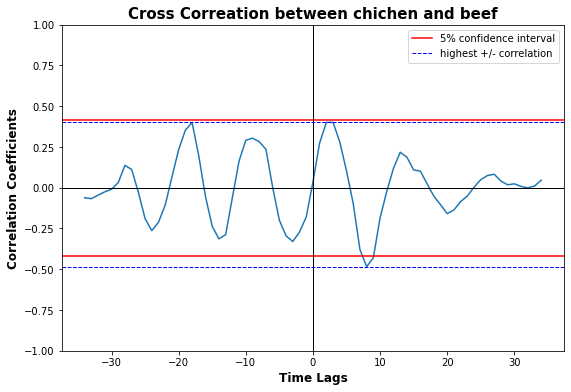

In [27]:
def ccf_plot(lags, ccf):
    fig, ax =plt.subplots(figsize=(9, 6))
    ax.plot(lags, ccf)
    ax.axhline(-2/np.sqrt(23), color='red', label='5% confidence interval')
    ax.axhline(2/np.sqrt(23), color='red')
    ax.axvline(x = 0, color = 'black', lw = 1)
    ax.axhline(y = 0, color = 'black', lw = 1)
    ax.axhline(y = np.max(ccf), color = 'blue', lw = 1, 
    linestyle='--', label = 'highest +/- correlation')
    ax.axhline(y = np.min(ccf), color = 'blue', lw = 1, 
    linestyle='--')
    ax.set(ylim = [-1, 1])
    ax.set_title('Cross Correation between chichen and beef', weight='bold', fontsize = 15)
    ax.set_ylabel('Correlation Coefficients', weight='bold', 
    fontsize = 12)
    ax.set_xlabel('Time Lags', weight='bold', fontsize = 12)
    plt.legend()
    
ccf_plot(lags, ccf_df)

### Working with the whole dataset

In [35]:
def create_tlcc_graph(df1, df2):
  df = pd.DataFrame({"df-1": df1.reshape(1,-1)[0], "df-2":df2.reshape(1,-1)[0]})
  df.apply(adf_test, axis = 0)
  ccf_df = ccf_values(df["df-1"], df["df-2"])
  lags = signal.correlation_lags(len(df["df-1"]), len(df["df-2"]))
  ccf_plot(lags, ccf_df)


# create_tlcc_graph(data['BirdChicken'][1], data['Beef'][1])

<Figure size 432x288 with 0 Axes>

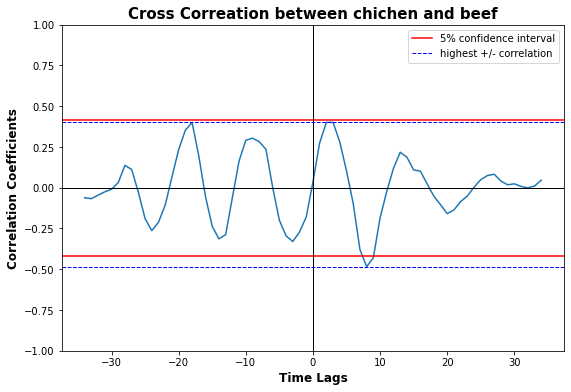

<Figure size 432x288 with 0 Axes>

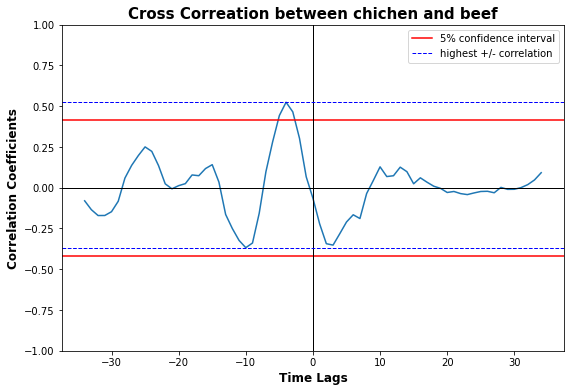

<Figure size 432x288 with 0 Axes>

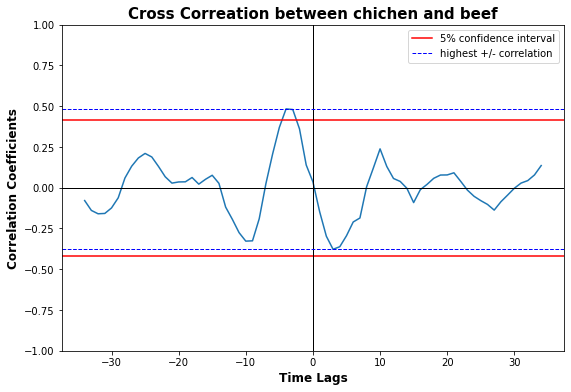

<Figure size 432x288 with 0 Axes>

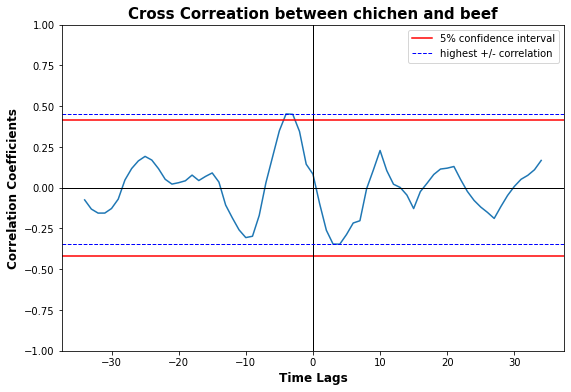

<Figure size 432x288 with 0 Axes>

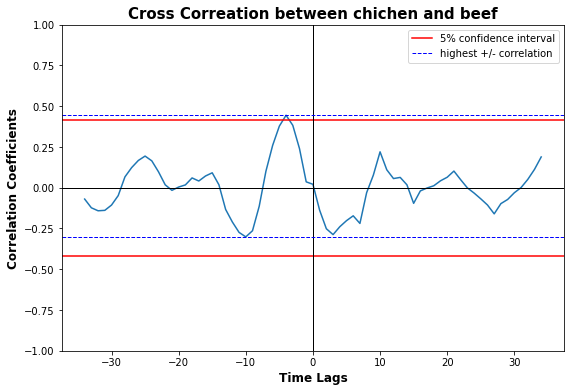

<Figure size 432x288 with 0 Axes>

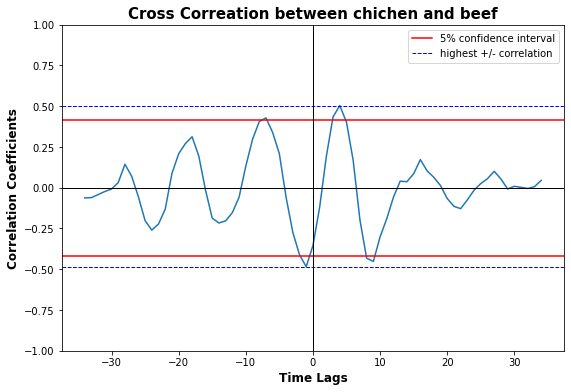

<Figure size 432x288 with 0 Axes>

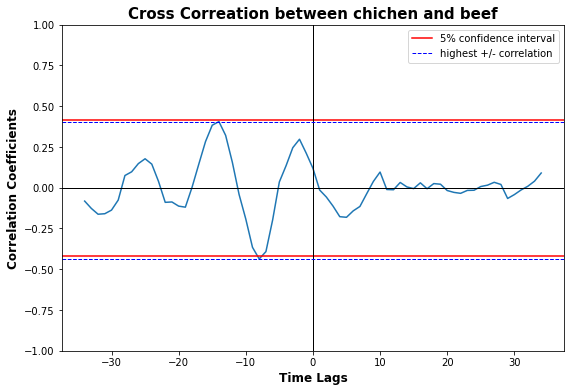

<Figure size 432x288 with 0 Axes>

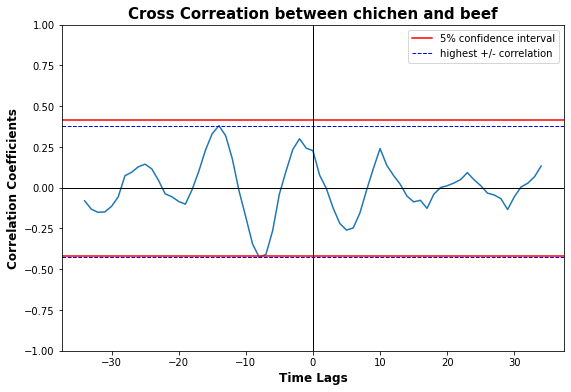

<Figure size 432x288 with 0 Axes>

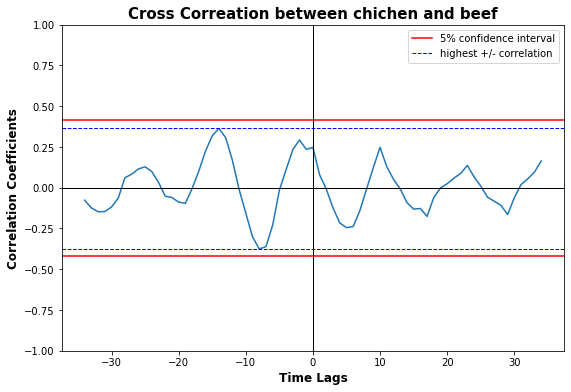

<Figure size 432x288 with 0 Axes>

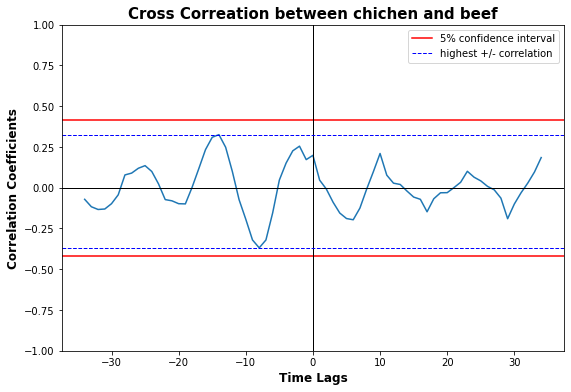

In [34]:
data1 = data['BirdChicken']
data2 = data['Beef']

for cl in data1.keys():
  for cll in data2.keys():
    plt.figure()
    create_tlcc_graph(data1[cl], data2[cll])